In [1]:
%pip install pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def load_data(filepath: str) -> pd.DataFrame:
    """
    Carrega os dados do arquivo CSV e realiza transformações iniciais.
    
    Args:
        filepath: Caminho para o arquivo CSV
        
    Returns:
        DataFrame com os dados carregados e processados
    """
    df = pd.read_csv(
        filepath, 
        names=['arquivo', 'k', 'best_ans', 'tempo_ms'],
        header=None
    )
    
    # Converter tempo de milissegundos para segundos
    df['tempo_seconds'] = df['tempo_ms'] / 1000.0
    
    return df

def load_data_vns(filepath: str) -> pd.DataFrame:
    """
    Carrega os dados do arquivo CSV do VNS Reativo e realiza transformações iniciais.
    
    Args:
        filepath: Caminho para o arquivo CSV
        
    Returns:
        DataFrame com os dados carregados e processados
    """
    df = pd.read_csv(
        filepath, 
        names=['arquivo', 'k', 'tempo_ms', 'best_ans'],
        header=None
    )
    
    # Converter tempo de milissegundos para segundos
    df['tempo_seconds'] = df['tempo_ms'] / 1000.0
    
    df = df[df['tempo_ms'] <= 40000]
    
    return df

def print_dataset_info(df: pd.DataFrame) -> None:
    """Exibe informações resumidas sobre o dataset."""
    print(f"Total de registros: {len(df):,}")
    print(f"\nPrimeiras linhas:")
    print(df.head())
    print(f"\nEstatísticas:")
    print(df[['best_ans', 'tempo_seconds']].describe())

# Carregar dados
df_aco = load_data('../Results/aco_kmis/result-1.csv')
df_graspts = load_data('../Results/graspts/result-1.csv')
df_vns = load_data_vns('../Results/vns_reactive/result-1.csv')

print_dataset_info(df_aco)
print("-------------")
print_dataset_info(df_graspts)
print("-------------")
print_dataset_info(df_vns)

Total de registros: 307,452

Primeiras linhas:
                                arquivo   k  best_ans  tempo_ms  tempo_seconds
0  ./Dataset/type1/classe_1_100_100.txt  11         6      32.0          0.032
1  ./Dataset/type1/classe_1_100_100.txt  11         6      62.0          0.062
2  ./Dataset/type1/classe_1_100_100.txt  11         7      92.0          0.092
3  ./Dataset/type1/classe_1_100_100.txt  11         7     122.0          0.122
4  ./Dataset/type1/classe_1_100_100.txt  11         7     152.0          0.152

Estatísticas:
            best_ans  tempo_seconds
count  307452.000000  307452.000000
mean       25.151389      20.004425
std        25.070477      11.551873
min         0.000000       0.002000
25%         4.000000       9.997000
50%        19.000000      19.994500
75%        40.000000      30.005250
max       233.000000      46.594000
-------------
Total de registros: 6,784

Primeiras linhas:
                                arquivo   k  best_ans  tempo_ms  tempo_seconds
0 

## Análise Comparativa: Evolução das Soluções

In [3]:
def prepare_time_series_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepara dados de série temporal com preenchimento de valores ausentes.
    Otimizado usando operações vetorizadas do pandas.
    
    Args:
        df: DataFrame original com dados
        
    Returns:
        DataFrame com médias por instância e grupo de tempo
    """
    # Preparar dados base
    df_sorted = df.sort_values('tempo_ms').copy()
    df_sorted['tempo_seconds_arounded'] = df_sorted['tempo_seconds'].round(2)
    
    # Agrupar por instância e tempo 
    # , calculando a média
    df_grouped = df_sorted.groupby(
        ['arquivo', 'tempo_seconds_arounded'], 
        as_index=False
    ).agg({'best_ans': 'mean'})
    
    print(f"Grouped structure 10 head:\n{df_grouped.head(10)}")
    
    # Criar índice completo (todas combinações de instância x tempo)
    instances = df['arquivo'].unique()
    time_groups = df_sorted['tempo_seconds_arounded'].unique()
    
    # Criar MultiIndex com todas as combinações
    full_index = pd.MultiIndex.from_product(
        [instances, sorted(time_groups)],
        names=['arquivo', 'tempo_seconds_arounded']
    )
    
    # Reindexar para incluir todas as combinações
    df_complete = df_grouped.set_index(['arquivo', 'tempo_seconds_arounded']).reindex(full_index)
    
    # Preencher valores ausentes com forward fill (propaga último valor válido)
    # e depois com 0 para os casos onde não há valor anterior
    df_complete['best_ans'] = df_complete.groupby(level='arquivo')['best_ans'].ffill().fillna(0)
    
    # É preciso tirar a média dos valores repetidos por grupo de tempo
    df_complete = df_complete.groupby(level=['arquivo', 'tempo_seconds_arounded'])['best_ans'].mean().to_frame()
    
    # Resetar índice e adicionar colunas auxiliares
    df_result = df_complete.reset_index()
    df_result['tempo_ms'] = df_result['tempo_seconds_arounded'] * 1000.0
    df_result['tempo_seconds'] = df_result['tempo_seconds_arounded']
    df_result['k'] = np.nan
    
    # Reordenar colunas para manter consistência
    df_result = df_result[['arquivo', 'k', 'best_ans', 'tempo_ms', 'tempo_seconds', 'tempo_seconds_arounded']]
    
    return df_result

In [4]:
df_instances_mean_by_group_time_aco = prepare_time_series_data(df_aco)
df_instances_mean_by_group_time_aco.head()

Grouped structure 10 head:
                                arquivo  tempo_seconds_arounded  best_ans
0  ./Dataset/type1/classe_1_100_100.txt                    0.03       6.0
1  ./Dataset/type1/classe_1_100_100.txt                    0.06       6.0
2  ./Dataset/type1/classe_1_100_100.txt                    0.09       7.0
3  ./Dataset/type1/classe_1_100_100.txt                    0.12       7.0
4  ./Dataset/type1/classe_1_100_100.txt                    0.15       7.0
5  ./Dataset/type1/classe_1_100_100.txt                    0.18       7.0
6  ./Dataset/type1/classe_1_100_100.txt                    0.21       7.0
7  ./Dataset/type1/classe_1_100_100.txt                    0.24       7.0
8  ./Dataset/type1/classe_1_100_100.txt                    0.27       7.0
9  ./Dataset/type1/classe_1_100_100.txt                    0.30       7.0


,arquivo,k,best_ans,tempo_ms,tempo_seconds,tempo_seconds_arounded
0,./Dataset/type1/classe_1_100_100.txt,NaN,0.0,0.0,0.00,0.00
1,./Dataset/type1/classe_1_100_100.txt,NaN,0.0,10.0,0.01,0.01
2,./Dataset/type1/classe_1_100_100.txt,NaN,0.0,20.0,0.02,0.02
3,./Dataset/type1/classe_1_100_100.txt,NaN,6.0,30.0,0.03,0.03
4,./Dataset/type1/classe_1_100_100.txt,NaN,6.0,40.0,0.04,0.04


In [5]:
df_instances_mean_by_group_time_graspts =prepare_time_series_data(df_graspts)
df_instances_mean_by_group_time_graspts.head()

Grouped structure 10 head:
                                arquivo  tempo_seconds_arounded  best_ans
0  ./Dataset/type1/classe_1_100_100.txt                    0.00  5.473684
1  ./Dataset/type1/classe_1_100_100.txt                    0.02  6.000000
2  ./Dataset/type1/classe_1_140_140.txt                    0.00  2.933333
3  ./Dataset/type1/classe_1_140_140.txt                    0.02  4.000000
4  ./Dataset/type1/classe_1_140_140.txt                    0.03  4.000000
5  ./Dataset/type1/classe_1_140_140.txt                    0.06  4.000000
6  ./Dataset/type1/classe_1_140_140.txt                    0.07  4.000000
7  ./Dataset/type1/classe_1_140_140.txt                    0.11  4.000000
8  ./Dataset/type1/classe_1_140_140.txt                    0.21  4.000000
9  ./Dataset/type1/classe_1_180_180.txt                    0.00  2.363636


,arquivo,k,best_ans,tempo_ms,tempo_seconds,tempo_seconds_arounded
0,./Dataset/type1/classe_1_100_100.txt,NaN,5.473684,0.0,0.00,0.00
1,./Dataset/type1/classe_1_100_100.txt,NaN,5.473684,10.0,0.01,0.01
2,./Dataset/type1/classe_1_100_100.txt,NaN,6.000000,20.0,0.02,0.02
3,./Dataset/type1/classe_1_100_100.txt,NaN,6.000000,30.0,0.03,0.03
4,./Dataset/type1/classe_1_100_100.txt,NaN,6.000000,40.0,0.04,0.04


In [6]:

df_instances_mean_by_group_time_vns = prepare_time_series_data(df_vns)
df_instances_mean_by_group_time_vns.head()

Grouped structure 10 head:
            arquivo  tempo_seconds_arounded  best_ans
0  classe_10_200_72                    0.00  1.000000
1  classe_10_200_72                    0.01  1.000000
2  classe_10_200_72                    0.02  0.944444
3  classe_10_200_72                    0.03  0.500000
4  classe_10_200_72                    0.04  0.500000
5  classe_10_200_72                    0.05  0.500000
6  classe_10_200_72                    0.06  0.500000
7  classe_10_200_72                    0.07  0.500000
8  classe_10_200_72                    0.08  0.500000
9  classe_10_200_72                    0.09  0.500000


,arquivo,k,best_ans,tempo_ms,tempo_seconds,tempo_seconds_arounded
0,classe_10_200_72,NaN,1.000000,0.0,0.00,0.00
1,classe_10_200_72,NaN,1.000000,10.0,0.01,0.01
2,classe_10_200_72,NaN,0.944444,20.0,0.02,0.02
3,classe_10_200_72,NaN,0.500000,30.0,0.03,0.03
4,classe_10_200_72,NaN,0.500000,40.0,0.04,0.04


# Plotar gráfico da média do best_ans ao longo do tempo

## Gráfico para o ACO

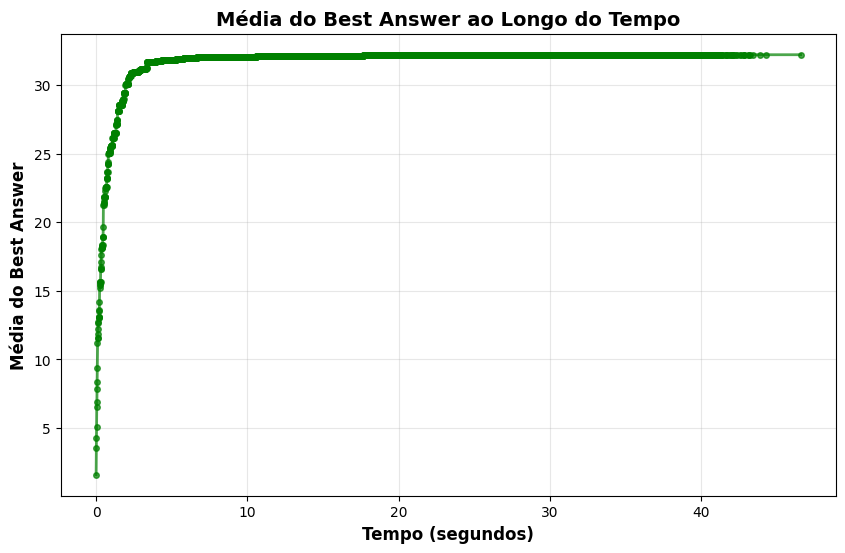

In [7]:
# Plotar gráfico da média do best_ans ao longo do tempo
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
mean_best_ans = df_instances_mean_by_group_time_aco.groupby('tempo_seconds_arounded')['best_ans'].mean().reset_index()
axes.plot(mean_best_ans['tempo_seconds_arounded'], mean_best_ans['best_ans'], marker='o', markersize=4, alpha=0.7, linewidth=2.0, color='green')
axes.set_xlabel('Tempo (segundos)', fontsize=12, fontweight='bold')
axes.set_ylabel('Média do Best Answer', fontsize=12, fontweight='bold')
axes.set_title('Média do Best Answer ao Longo do Tempo', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

Grouped structure 10 head:
                                arquivo  tempo_seconds_arounded  best_ans
0  ./Dataset/type4/classe_10_200_66.txt                    0.24       0.0
1  ./Dataset/type4/classe_10_200_66.txt                    0.50       0.0
2  ./Dataset/type4/classe_10_200_72.txt                    0.10       1.0
3  ./Dataset/type4/classe_10_200_72.txt                    0.21       1.0
4  ./Dataset/type4/classe_10_200_72.txt                    0.31       1.0
5  ./Dataset/type4/classe_10_200_72.txt                    0.42       1.0
6  ./Dataset/type4/classe_10_200_74.txt                    0.25       0.0
7  ./Dataset/type4/classe_10_200_75.txt                    0.12       1.0
8  ./Dataset/type4/classe_10_200_75.txt                    0.24       1.0
9  ./Dataset/type4/classe_10_200_75.txt                    0.37       1.0


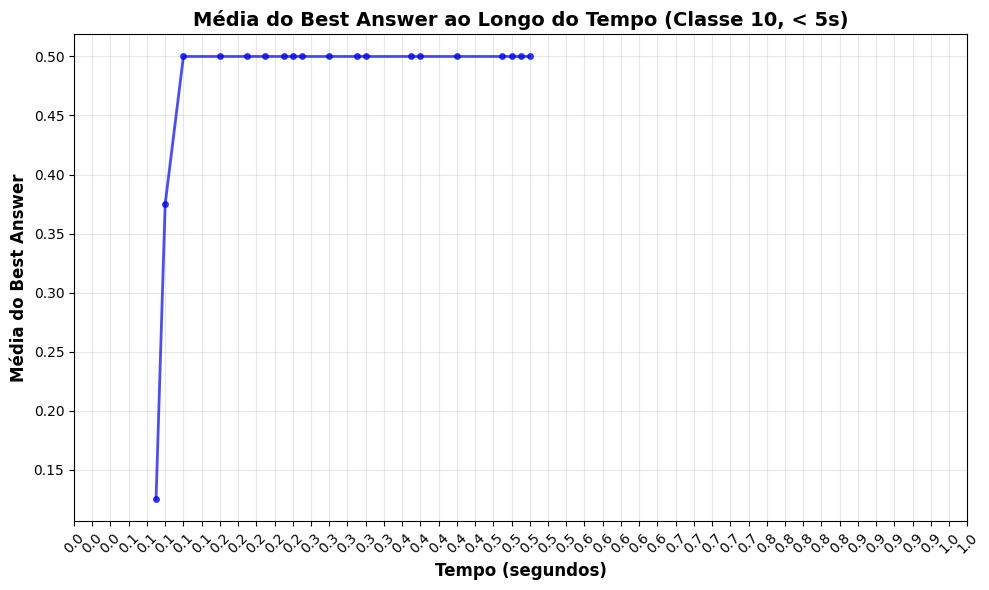

In [8]:
# Plotar gráfico da média do best_ans somente para instancia da classe 10

df_class_10 = df_aco[(df_aco['arquivo'].str.contains('classe_10')) & (df_aco['tempo_seconds'] < 0.5)]
df_instances_mean_by_group_time_class_10 = prepare_time_series_data(df_class_10)
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
mean_best_ans_class_10 = df_instances_mean_by_group_time_class_10.groupby('tempo_seconds_arounded')['best_ans'].mean().reset_index()
axes.plot(mean_best_ans_class_10['tempo_seconds_arounded'], mean_best_ans_class_10['best_ans'], marker='o', markersize=4, alpha=0.7, linewidth=2.0, color='blue')
# labels do tempo em intervalo de 0.5 em 0.5 segundos
labels = np.arange(0, mean_best_ans_class_10['tempo_seconds_arounded'].max() + 0.5, 0.02)
axes.set_xticks(labels)
axes.set_xticklabels([f'{x:.1f}' for x in labels], rotation=45)
axes.set_xlabel('Tempo (segundos)', fontsize=12, fontweight='bold')
axes.set_ylabel('Média do Best Answer', fontsize=12, fontweight='bold')
axes.set_title('Média do Best Answer ao Longo do Tempo (Classe 10, < 5s)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Plotar gráfico do GRASPTS

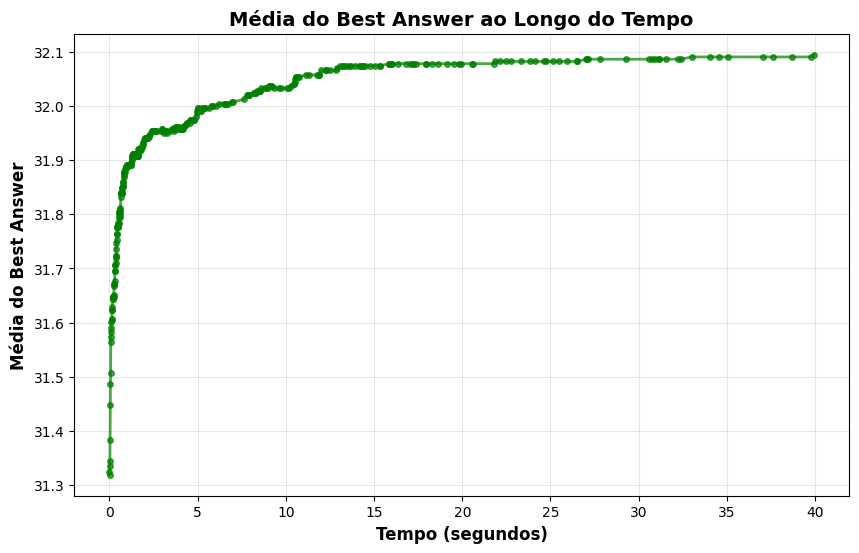

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
mean_best_ans = df_instances_mean_by_group_time_graspts.groupby('tempo_seconds_arounded')['best_ans'].mean().reset_index()
axes.plot(mean_best_ans['tempo_seconds_arounded'], mean_best_ans['best_ans'], marker='o', markersize=4, alpha=0.7, linewidth=2.0, color='green')
axes.set_xlabel('Tempo (segundos)', fontsize=12, fontweight='bold')
axes.set_ylabel('Média do Best Answer', fontsize=12, fontweight='bold')
axes.set_title('Média do Best Answer ao Longo do Tempo', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

Grouped structure 10 head:
                                arquivo  tempo_seconds_arounded  best_ans
0  ./Dataset/type4/classe_10_200_66.txt                    0.24       0.0
1  ./Dataset/type4/classe_10_200_66.txt                    0.50       0.0
2  ./Dataset/type4/classe_10_200_66.txt                    0.75       0.0
3  ./Dataset/type4/classe_10_200_66.txt                    1.00       0.0
4  ./Dataset/type4/classe_10_200_72.txt                    0.10       1.0
5  ./Dataset/type4/classe_10_200_72.txt                    0.21       1.0
6  ./Dataset/type4/classe_10_200_72.txt                    0.31       1.0
7  ./Dataset/type4/classe_10_200_72.txt                    0.42       1.0
8  ./Dataset/type4/classe_10_200_72.txt                    0.52       1.0
9  ./Dataset/type4/classe_10_200_72.txt                    0.63       1.0


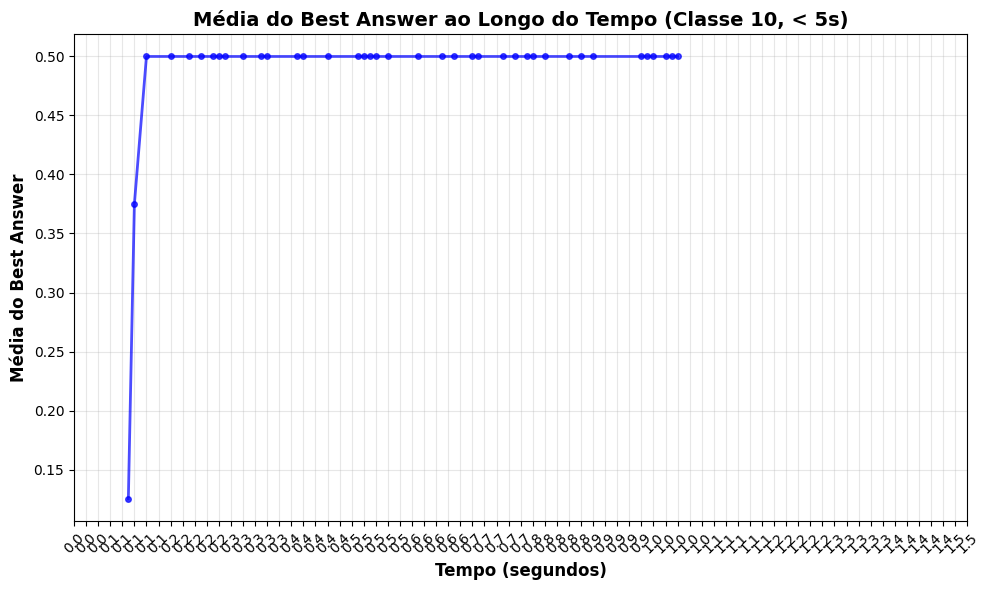

In [10]:
# Plotar gráfico da média do best_ans ao longo do tempo para classe 10 - GRASPts

df_class_10 = df_aco[(df_aco['arquivo'].str.contains('classe_10')) & (df_aco['tempo_seconds'] < 1)]
df_instances_mean_by_group_time_class_10 = prepare_time_series_data(df_class_10)
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
mean_best_ans_class_10 = df_instances_mean_by_group_time_class_10.groupby('tempo_seconds_arounded')['best_ans'].mean().reset_index()
axes.plot(mean_best_ans_class_10['tempo_seconds_arounded'], mean_best_ans_class_10['best_ans'], marker='o', markersize=4, alpha=0.7, linewidth=2.0, color='blue')
# labels do tempo em intervalo de 0.5 em 0.5 segundos
labels = np.arange(0, mean_best_ans_class_10['tempo_seconds_arounded'].max() + 0.5, 0.02)
axes.set_xticks(labels)
axes.set_xticklabels([f'{x:.1f}' for x in labels], rotation=45)
axes.set_xlabel('Tempo (segundos)', fontsize=12, fontweight='bold')
axes.set_ylabel('Média do Best Answer', fontsize=12, fontweight='bold')
axes.set_title('Média do Best Answer ao Longo do Tempo (Classe 10, < 5s)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Plotar gráfico VNS Reativo

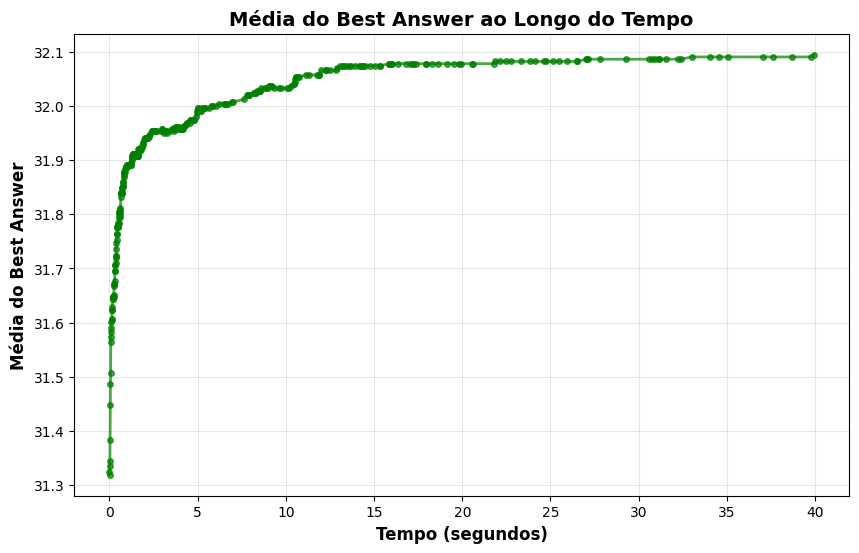

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
mean_best_ans = df_instances_mean_by_group_time_graspts.groupby('tempo_seconds_arounded')['best_ans'].mean().reset_index()
axes.plot(mean_best_ans['tempo_seconds_arounded'], mean_best_ans['best_ans'], marker='o', markersize=4, alpha=0.7, linewidth=2.0, color='green')
axes.set_xlabel('Tempo (segundos)', fontsize=12, fontweight='bold')
axes.set_ylabel('Média do Best Answer', fontsize=12, fontweight='bold')
axes.set_title('Média do Best Answer ao Longo do Tempo', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

Grouped structure 10 head:
                                arquivo  tempo_seconds_arounded  best_ans
0  ./Dataset/type4/classe_10_200_66.txt                    0.24       0.0
1  ./Dataset/type4/classe_10_200_66.txt                    0.50       0.0
2  ./Dataset/type4/classe_10_200_72.txt                    0.10       1.0
3  ./Dataset/type4/classe_10_200_72.txt                    0.21       1.0
4  ./Dataset/type4/classe_10_200_72.txt                    0.31       1.0
5  ./Dataset/type4/classe_10_200_72.txt                    0.42       1.0
6  ./Dataset/type4/classe_10_200_74.txt                    0.25       0.0
7  ./Dataset/type4/classe_10_200_75.txt                    0.12       1.0
8  ./Dataset/type4/classe_10_200_75.txt                    0.24       1.0
9  ./Dataset/type4/classe_10_200_75.txt                    0.37       1.0


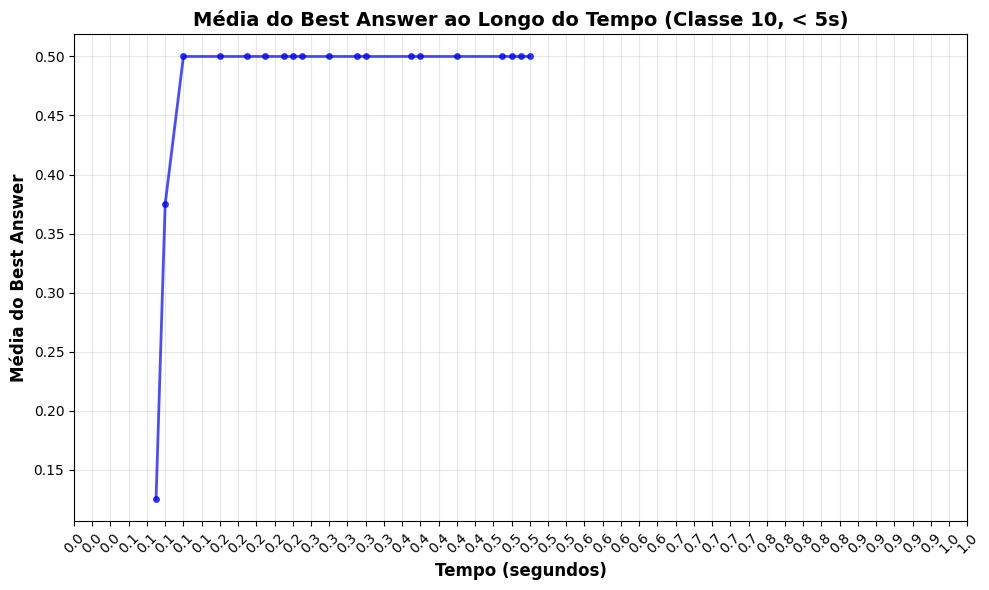

In [12]:
# Plotar gráfico da média do best_ans ao longo do tempo para a classe 10 - VNS Reativo

df_class_10 = df_aco[(df_aco['arquivo'].str.contains('classe_10')) & (df_aco['tempo_seconds'] < 0.5)]
df_instances_mean_by_group_time_class_10 = prepare_time_series_data(df_class_10)
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
mean_best_ans_class_10 = df_instances_mean_by_group_time_class_10.groupby('tempo_seconds_arounded')['best_ans'].mean().reset_index()
axes.plot(mean_best_ans_class_10['tempo_seconds_arounded'], mean_best_ans_class_10['best_ans'], marker='o', markersize=4, alpha=0.7, linewidth=2.0, color='blue')
# labels do tempo em intervalo de 0.5 em 0.5 segundos
labels = np.arange(0, mean_best_ans_class_10['tempo_seconds_arounded'].max() + 0.5, 0.02)
axes.set_xticks(labels)
axes.set_xticklabels([f'{x:.1f}' for x in labels], rotation=45)
axes.set_xlabel('Tempo (segundos)', fontsize=12, fontweight='bold')
axes.set_ylabel('Média do Best Answer', fontsize=12, fontweight='bold')
axes.set_title('Média do Best Answer ao Longo do Tempo (Classe 10, < 5s)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Calcular gráfico comparativo

Shape final: (67344, 4)
Registros ACO: 1,008,354
Registros GRASPTS: 82,522
Registros VNS: 173,030

Primeiras linhas:
                                arquivo  tempo_seconds_arounded algoritmo  \
0  ./Dataset/type1/classe_1_100_100.txt                     0.0       ACO   
1  ./Dataset/type1/classe_1_100_100.txt                     0.0   GRASPTS   
2  ./Dataset/type1/classe_1_100_100.txt                     0.0       VNS   
3  ./Dataset/type1/classe_1_100_100.txt                     1.0       ACO   
4  ./Dataset/type1/classe_1_100_100.txt                     1.0   GRASPTS   
5  ./Dataset/type1/classe_1_100_100.txt                     1.0       VNS   
6  ./Dataset/type1/classe_1_100_100.txt                     2.0       ACO   
7  ./Dataset/type1/classe_1_100_100.txt                     2.0   GRASPTS   
8  ./Dataset/type1/classe_1_100_100.txt                     2.0       VNS   
9  ./Dataset/type1/classe_1_100_100.txt                     3.0       ACO   

   best_ans  
0  6.470588  
1  5.97

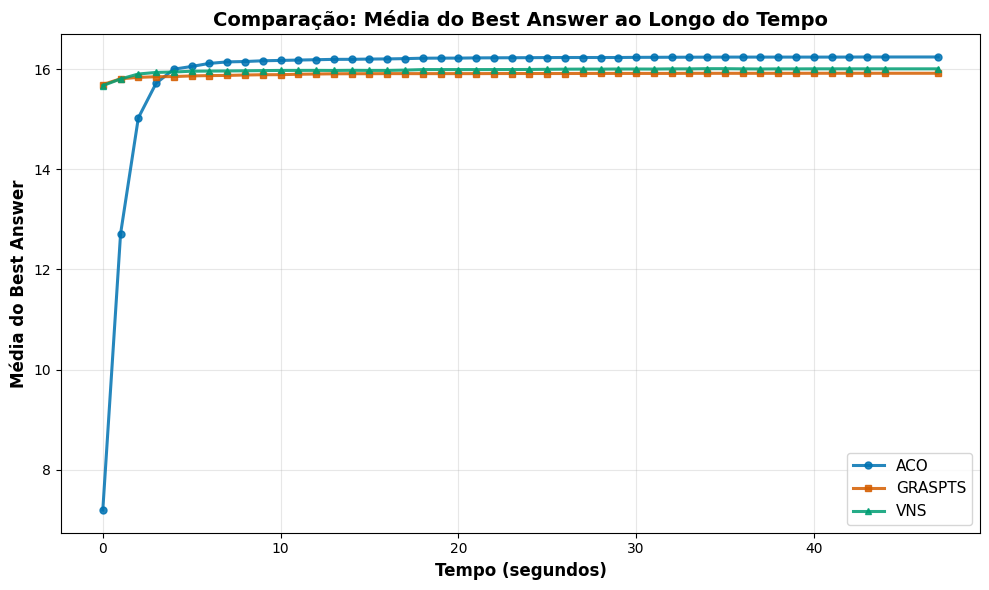

In [13]:
def concat_dfs_with_prefix(df_aco: pd.DataFrame, df_graspts: pd.DataFrame, df_vns: pd.DataFrame) -> pd.DataFrame:
    """
    Concatena ACO, GRASPTS e VNS DataFrames verticalmente, adicionando coluna de origem.

    Args:
        df_aco: DataFrame com dados do ACO
        df_graspts: DataFrame com dados do GRASPTS
        df_vns: DataFrame com dados do VNS

    Returns:
        DataFrame concatenado com coluna 'algoritmo' identificando a origem
    """
    # Adicionar coluna de origem em cada DataFrame
    df_aco_copy = df_aco.copy()
    df_aco_copy['algoritmo'] = 'ACO'

    df_vns_copy = df_vns.copy()
    df_vns_copy['algoritmo'] = 'VNS'

    df_graspts_copy = df_graspts.copy()
    df_graspts_copy['algoritmo'] = 'GRASPTS'
    
    # Concatenar verticalmente (empilhar)
    df_concat = pd.concat([df_aco_copy, df_vns_copy, df_graspts_copy], ignore_index=True)

    # ARREDONDAR os tempos para reduzir o número de grupos e evitar explosão de memória
    df_concat['tempo_seconds_arounded'] = df_concat['tempo_seconds_arounded'].round(0)  # arredonda para o inteiro mais próximo

    # Garantir unicidade para o índice composto
    df_concat = df_concat.groupby(['arquivo', 'tempo_seconds_arounded', 'algoritmo'], as_index=False)['best_ans'].mean()

    # Juntar os "tempo_seconds_arounded" dos algoritmos
    all_item_intervals = sorted(df_concat['tempo_seconds_arounded'].unique())

    # Garantir que todos os tempos estejam presentes para todos os algoritmos
    full_index = pd.MultiIndex.from_product(
        [df_concat['arquivo'].unique(), all_item_intervals, ['ACO', 'VNS', 'GRASPTS']],
        names=['arquivo', 'tempo_seconds_arounded', 'algoritmo']
    )

    # Preencher valores ausentes com o último valor válido menor que o tempo a ser preenchido ou zero
    df_concat = df_concat.set_index(
        ['arquivo', 'tempo_seconds_arounded', 'algoritmo']
    ).reindex(full_index)
    

    df_concat['best_ans'] = df_concat.groupby(level=['arquivo', 'algoritmo'])['best_ans'].ffill().fillna(0)
    
    # Para as instâncias que estão repetidas dentro de um grupo de tempo, deve tirar a média desses resultados para evitar distorções
    df_concat = df_concat.groupby(level=['arquivo', 'tempo_seconds_arounded', 'algoritmo'])['best_ans'].mean().to_frame()
    
    df_concat = df_concat.reset_index() 

    print(f"Shape final: {df_concat.shape}")
    print(f"Registros ACO: {len(df_aco_copy):,}")
    print(f"Registros GRASPTS: {len(df_graspts_copy):,}")
    print(f"Registros VNS: {len(df_vns_copy):,}")
    print(f"\nPrimeiras linhas:\n{df_concat.head(10)}")

    return df_concat

# Concatenar os DataFrames
df_combined = concat_dfs_with_prefix(
    df_instances_mean_by_group_time_aco,
    df_instances_mean_by_group_time_graspts,
    df_instances_mean_by_group_time_vns
)

# Calcular médias por algoritmo e tempo
df_plot = df_combined.groupby(['algoritmo', 'tempo_seconds_arounded'])[
    'best_ans'].mean().reset_index()

# Plotar gráfico comparativo com cores modernas e acessíveis
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

# Paleta de cores mais agradável e acessível
color_map = {
    'ACO': '#0072B2',      # azul escuro
    'GRASPTS': '#D55E00',  # laranja escuro
    'VNS': '#009E73'       # verde escuro
}
marker_map = {
    'ACO': 'o',
    'GRASPTS': 's',
    'VNS': '^'
}

for algoritmo in ['ACO', 'GRASPTS', 'VNS']:
    df_alg = df_plot[df_plot['algoritmo'] == algoritmo]
    axes.plot(df_alg['tempo_seconds_arounded'], df_alg['best_ans'],
              marker=marker_map[algoritmo], markersize=5, alpha=0.85, linewidth=2.2,
              color=color_map[algoritmo], label=algoritmo)

axes.set_xlabel('Tempo (segundos)', fontsize=12, fontweight='bold')
axes.set_ylabel('Média do Best Answer', fontsize=12, fontweight='bold')
max_tempo = df_plot['tempo_seconds_arounded'].max()
# axes.set_xticks(np.arange(0, max_tempo + 1, 3))
axes.set_title('Comparação: Média do Best Answer ao Longo do Tempo',
               fontsize=14, fontweight='bold')
axes.legend(fontsize=11, frameon=True, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
df_instances_mean_by_group_time_aco['best_ans'].mean()

np.float64(31.6691117405197)

In [15]:
df_instances_mean_by_group_time_vns['best_ans'].mean()

np.float64(32.074909636918335)

In [16]:
df_instances_mean_by_group_time_graspts['best_ans'].mean()

np.float64(31.93124898397564)